In [596]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import zz_feature_map
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
# import svc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Load dataset

In [597]:
n_features = 3
n_classes = 2
n_informative_features = 2
n_redundant = n_features - n_informative_features
n_clusters_per_class = 1
X, y = make_classification(n_samples=300,
                           n_classes = n_classes,
                           n_features=n_features,
                           n_informative=n_informative_features,
                           n_redundant=n_redundant,
                           n_clusters_per_class=n_clusters_per_class,
                           random_state=42, shuffle=True)
print(X.shape)
print(y.shape)



(300, 3)
(300,)


In [598]:
# Use standard scaler to normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

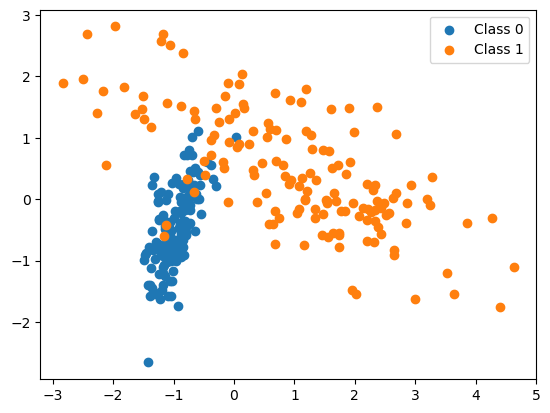

In [599]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
for c in np.unique(y):
    plt.scatter(X_pca[y==c, 0], X_pca[y==c, 1], label=f'Class {c}')
plt.legend()
plt.show()

In [600]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create circuit

In [601]:
n_qubits = X.shape[1]
print(f"Number of qubits: {n_qubits}")


Number of qubits: 3


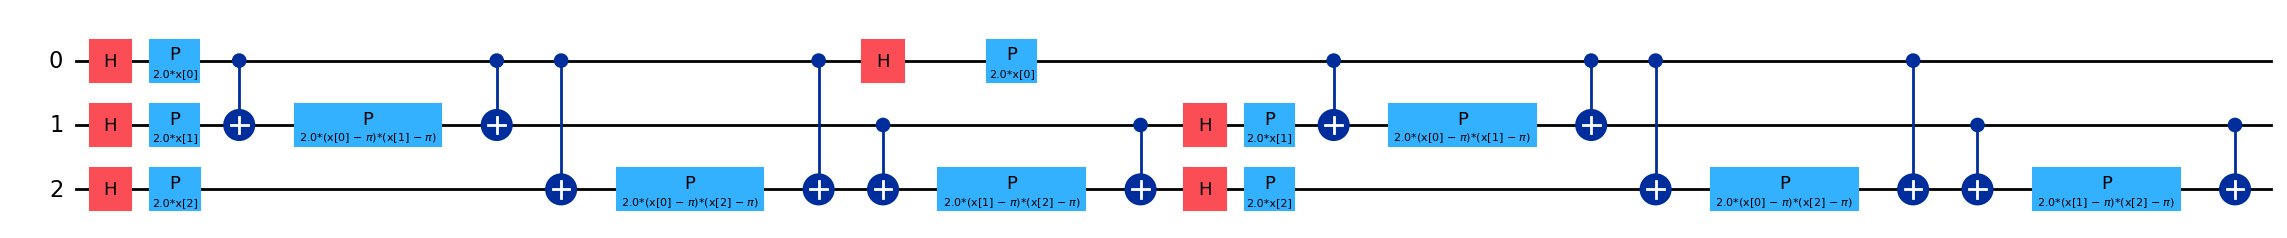

In [602]:
# Create the encoding circuit
enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')

enc_qc.draw('mpl', fold=-1)

# Create QCBM

In [603]:
# Create a QCBM where:
#  -the circuit is the encoding circuit
#  -the data is data for each class
#  -the objective is to find the parameters "theta" that reproduce each class

In [604]:
import numpy as np

def float_to_nbit_bin(x, N, min_val, max_val):
    levels = 2**N
    # Clamp value to range
    x_clamped = max(min_val, min(max_val, x))
    # Normalize to [0, 1]
    normalized = (x_clamped - min_val) / (max_val - min_val)
    # Quantize
    quantized = int(round(normalized * (levels - 1)))
    # Convert to binary
    return format(quantized, f'0{N}b')

def nbit_bin_to_float(bstr, N, min_val, max_val):
    levels = 2**N
    value = int(bstr, 2)
    normalized = value / (levels - 1)
    return min_val + normalized * (max_val - min_val)


In [605]:
def encode_data_into_bitstring(X):
    """
    Encode the data into bitstrings
    """
    n_qubits = 1#X.shape[1]
    min_vals_per_col = X.min(axis=0)
    max_vals_per_col = X.max(axis=0)

    # Create an array to hold the encoded data
    X_encoded = np.zeros((X.shape[0], X.shape[1]), dtype=object)
    
    # Map each matrix point to a bitstring
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Encode each feature into a bitstring
            X_encoded[i, j] = float_to_nbit_bin(X[i, j], n_qubits, min_vals_per_col[j], max_vals_per_col[j])

    return X_encoded, min_vals_per_col, max_vals_per_col
    
def decode_bitstring_to_data(X_encoded, min_vals_per_col, max_vals_per_col):
    """
    Decode the bitstrings back to data
    """
    n_qubits = len(X_encoded[0, 0])  # Number of bits in each bitstring
    
    # Create an array to hold the decoded data
    X_decoded = np.zeros((X_encoded.shape[0], X_encoded.shape[1]))
    
    # Map each bitstring back to a matrix point
    for i in range(X_encoded.shape[0]):
        for j in range(X_encoded.shape[1]):
            # Decode each bitstring back to a feature
            X_decoded[i, j] = nbit_bin_to_float(X_encoded[i, j], n_qubits, min_vals_per_col[j], max_vals_per_col[j])

    return X_decoded

In [606]:
X_enc, min_vals_per_col, max_vals_per_col = encode_data_into_bitstring(X_train)

In [607]:
def separate_into_classes(X,y):
    """
    Separate the data into classes
    """
    unique_classes = np.unique(y)
    class_data = {}
    for c in unique_classes:
        class_data[int(c)] = X[y==c]
    return class_data

In [608]:
# Separate the data into classes
class_data = separate_into_classes(X_enc, y_train)

In [609]:
from collections import Counter
def create_prob_distribution(X_enc):
    bitstrings = []
    nums = []
    for d in X_enc:
        bitstrings += ["".join(str(int(i)) for i in d)]
        nums += [int(bitstrings[-1], 2)]
    bitstrings = np.array(bitstrings)
    nums = np.array(nums)

    # Count occurrences
    count = Counter(zip(nums, bitstrings))

    # Unique nums and bitstrings
    unique_nums = []
    unique_bitstrings = []
    probs = np.zeros(2**n_qubits)

    # Ensure counts are ordered from 000... to 1111...
    count_dict = count.items()
    count = dict(sorted(count_dict, key=lambda x: (x[0][1], x[0][0])))

    for (num, bitstring), freq in count.items():
        unique_nums.append(num)
        unique_bitstrings.append(bitstring)
        probs[num] = freq / len(X_enc)
    
    return unique_nums, unique_bitstrings, probs

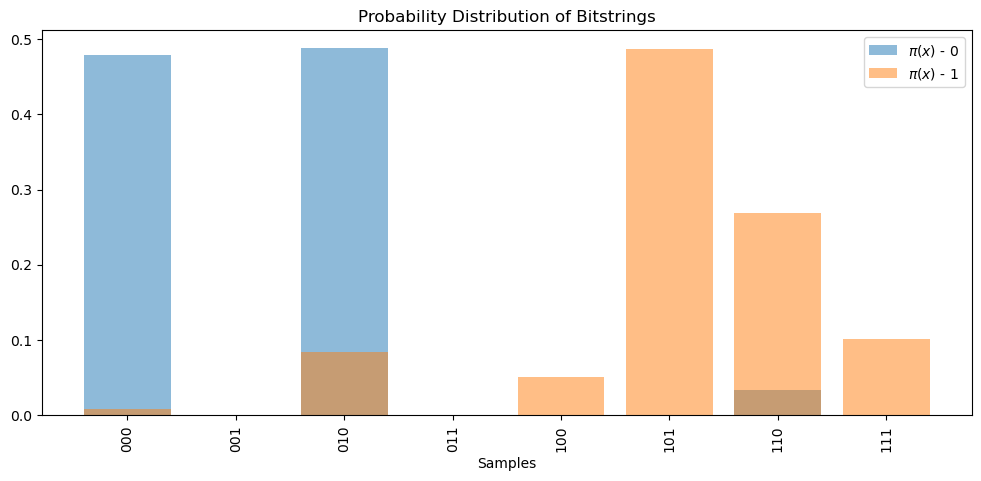

In [610]:

class_data_probs = {}
for c in class_data.keys():
    class_data_probs[c] = create_prob_distribution(class_data[c])


# Plot class 0
unique_nums0, unique_bitstrings0, probs0 = class_data_probs[0]
unique_nums1, unique_bitstrings1, probs1 = class_data_probs[1]
plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**n_qubits), probs0, label=r"$\pi(x)$ - 0", alpha=0.5)
plt.bar(np.arange(2**n_qubits), probs1, label=r"$\pi(x)$ - 1", alpha=0.5)
plt.xticks(np.arange(2**n_qubits), [f"{i:0{n_qubits}b}" for i in range(2**n_qubits)], rotation=90)
plt.legend()

plt.title("Probability Distribution of Bitstrings")
plt.xlabel("Samples")
plt.show()

In [611]:
# Make the probs "counts" like
og_counts_list = []
for cls in class_data_probs.keys():
    unique_nums, unique_bitstrings, probs = class_data_probs[cls]
    counts = {}
    for i in range(2**n_qubits):
        if probs[i] > 0.0:
            # Convert the bitstring to a number
            i_in_binary = format(i, f'0{n_qubits}b')
            counts[i_in_binary] = float(probs[i])
    og_counts_list.append(counts)

In [612]:
og_counts_list

[{'000': 0.4793388429752066,
  '010': 0.48760330578512395,
  '110': 0.03305785123966942},
 {'000': 0.008403361344537815,
  '010': 0.08403361344537816,
  '100': 0.05042016806722689,
  '101': 0.48739495798319327,
  '110': 0.2689075630252101,
  '111': 0.10084033613445378}]

In [613]:
from qiskit.quantum_info import Statevector, SparsePauliOp
def create_fidelity_observable(quasi_dist):
    """
    Create a fidelity observable from a quasi-distribution.
    """
    n_qubits = len(next(iter(quasi_dist)))
    operator = SparsePauliOp(["I" * n_qubits], [0.0])  # Start from zero operator

    for bs, prob in quasi_dist.items():
        statevector = Statevector.from_label(bs)
        operator_n = SparsePauliOp.from_operator(statevector.to_operator())
        operator += prob * operator_n  # Scale by probability and accumulate
    operator_s = operator.simplify()  # Reduce the operator to its simplest form
    assert np.all(operator_s.to_matrix() == operator.to_matrix()), "Operator not simplified correctly"
    return operator_s


In [614]:
fidelity_operators = [ create_fidelity_observable(og_counts) for og_counts in og_counts_list]

In [615]:
from qiskit_ibm_runtime import Estimator
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, SparsePauliOp

def run_estimator(pubs, shots):
    backend = AerSimulator()
    estimator = Estimator(mode=backend, options={'default_shots': shots})

    job = estimator.run(pubs)
    return job.result()

In [616]:
import tqdm
from scipy.optimize import minimize, OptimizeResult
def train_qcbm(qc, fidelity_operator):

    initial_point = np.random.rand(qc.num_parameters) * 2 * np.pi
    # Define the objective function to minimize
    def objective_function(theta):
        # Create the quantum circuit with the given parameters
        qc_assigned = qc.assign_parameters(theta, inplace=False)
        
        # Simulate the circuit
        shots = 10000
        pubs = [(qc_assigned, fidelity_operator)]
        result = run_estimator(pubs, shots)
        exp_value = result[0].data.evs.tolist()

        # Compute the loss
        computed_loss = 1 - exp_value  # Fidelity loss (1 - fidelity)
        return computed_loss
    # Use a classical optimizer to minimize the objective function

    # Callback
    i_results = []
    maxfev = 400
    pr_bar = tqdm.tqdm(total=maxfev, desc="Training", position=0, leave=True)
    def callback(intermediate_result: OptimizeResult):
        i_results.append(intermediate_result.fun)
        pr_bar.update(1)

    # Optimizer
    optimizer = 'COBYQA'
    result = minimize(objective_function,
                    initial_point.copy(),
                    method=optimizer,
                    options={'maxfev': maxfev},
                    callback=callback)

    print("Final result:")
    print(result)
    final_parameters = result.x
    final_loss = result.fun

    return final_parameters, final_loss, i_results
    

In [617]:
fidelity_operators

[SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
               coeffs=[ 0.125     +0.j,  0.125     +0.j, -0.00516529+0.j, -0.00516529+0.j,
   0.11673554+0.j,  0.11673554+0.j,  0.00309917+0.j,  0.00309917+0.j]),
 SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
               coeffs=[ 0.125     +0.j, -0.02205882+0.j,  0.01155462+0.j, -0.08508403+0.j,
  -0.10189076+0.j,  0.04516807+0.j, -0.03046218+0.j,  0.06617647+0.j])]

Training QCBM for class 0
Fidelity operator for class 0:
SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[ 0.125     +0.j,  0.125     +0.j, -0.00516529+0.j, -0.00516529+0.j,
  0.11673554+0.j,  0.11673554+0.j,  0.00309917+0.j,  0.00309917+0.j])


Training:  16%|█▋        | 66/400 [00:02<00:12, 26.56it/s]


Final result:
 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: 0.5450280991735537
       x: [ 1.401e+00  2.222e+00  4.878e+00]
     nit: 39
   maxcv: 0.0
    nfev: 66
Final loss for class 0: 0.5450280991735537
Training QCBM for class 1
Fidelity operator for class 1:
SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[ 0.125     +0.j, -0.02205882+0.j,  0.01155462+0.j, -0.08508403+0.j,
 -0.10189076+0.j,  0.04516807+0.j, -0.03046218+0.j,  0.06617647+0.j])


Training:  16%|█▌        | 63/400 [00:02<00:12, 27.17it/s]


Final result:
 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: 0.7859033613445378
       x: [ 7.622e-01  6.042e+00  5.575e+00]
     nit: 42
   maxcv: 0.0
    nfev: 63
Final loss for class 1: 0.7859033613445378


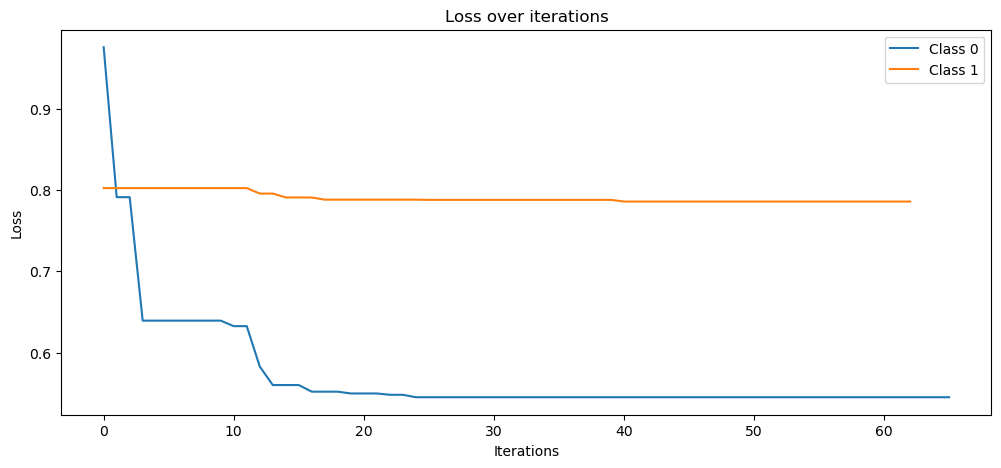

In [618]:
best_x_list = []
lost_i_res_list = []
for cls in range(len(og_counts_list)):
    print(f"Training QCBM for class {cls}")

    op = fidelity_operators[cls]
    print(f"Fidelity operator for class {cls}:")
    print(op)
    # Train the QCBM
    final_parameters, final_loss, i_results = train_qcbm(enc_qc, op)
    print(f"Final loss for class {cls}: {final_loss}")

    best_x_list.append(final_parameters)
    lost_i_res_list.append(i_results)
# Plot the loss over iterations
plt.figure(figsize=(12, 5))
plt.plot(lost_i_res_list[0], label='Class 0')
plt.plot(lost_i_res_list[1], label='Class 1')
plt.title("Loss over iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [619]:
print("Final parameters for class 0:")
print(best_x_list[0])
print("Final parameters for class 1:")
print(best_x_list[1])

Final parameters for class 0:
[1.40147393 2.22214506 4.87751013]
Final parameters for class 1:
[0.76215078 6.04199009 5.57527561]


In [620]:
# test with sampler
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, SparsePauliOp

def run_sampler(pubs, shots):
    backend = AerSimulator()
    sampler = Sampler(mode=backend, options={'default_shots': shots})

    job = sampler.run(pubs)
    return job.result()
def run_qcbm(qc, params):
    # Create the quantum circuit with the given parameters
    qc_assigned = qc.assign_parameters(params, inplace=False)
    qc_assigned.measure_all()
    
    # Simulate the circuit
    shots = 10000
    pubs = [(qc_assigned)]
    result = run_sampler(pubs, shots)
    counts = result[0].data.meas.get_counts()
    # Convert counts to probabilities
    total_counts = sum(counts.values())
    probs = np.zeros(2**n_qubits)
    for i in range(2**n_qubits):
        i_in_binary = format(i, f'0{n_qubits}b')
        if i_in_binary in counts:
            probs[i] = counts[i_in_binary] / total_counts
        else:
            probs[i] = 0.0

    return probs

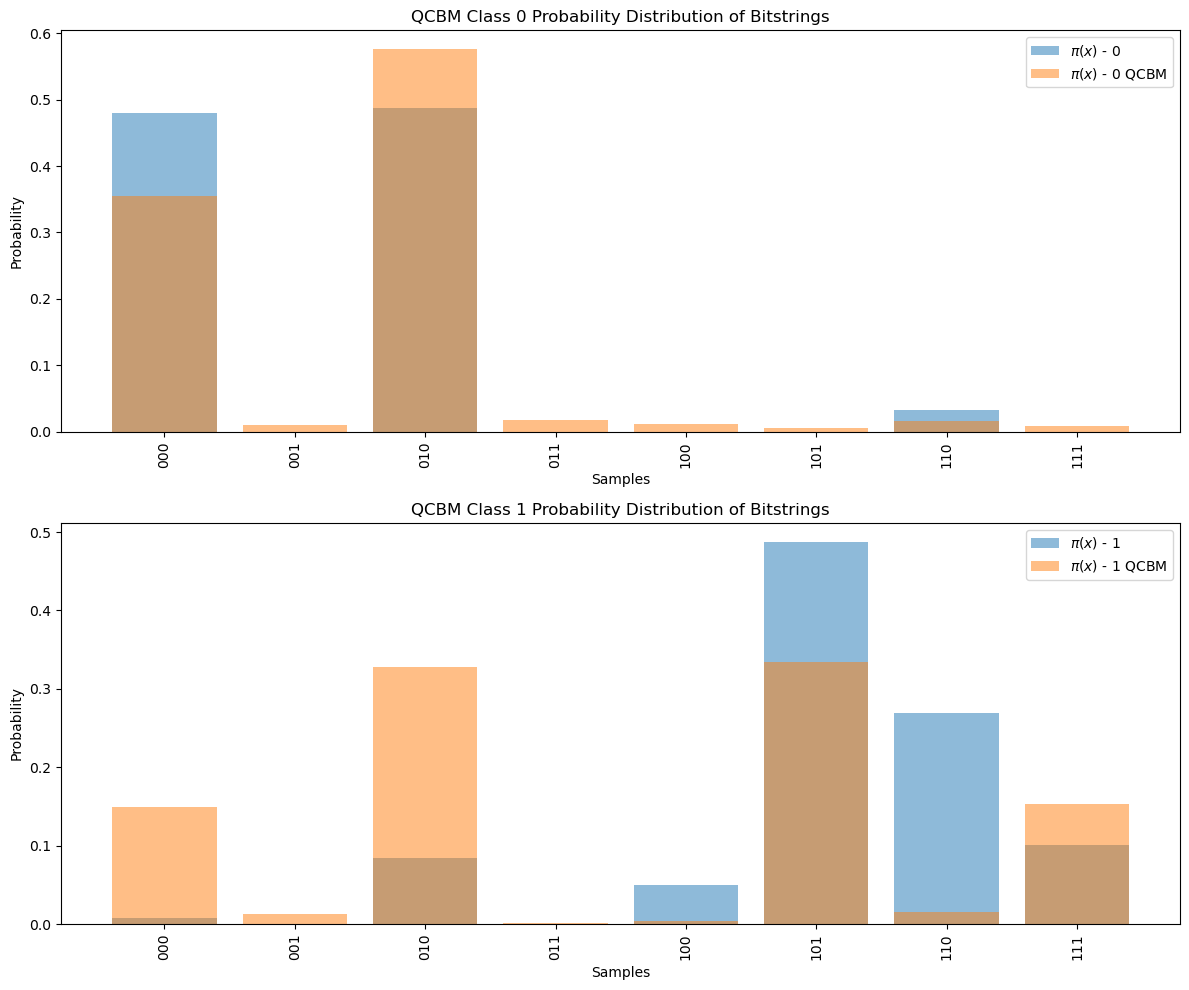

In [621]:
# Plot original distributions and QCBM distributions
qcbm_cls_0 = run_qcbm(enc_qc, best_x_list[0])
qcbm_cls_1 = run_qcbm(enc_qc, best_x_list[1])
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].bar(np.arange(2**n_qubits), probs0, label=r"$\pi(x)$ - 0", alpha=0.5)
ax[0].bar(np.arange(2**n_qubits), qcbm_cls_0, label=r"$\pi(x)$ - 0 QCBM", alpha=0.5)
ax[0].set_xticks(np.arange(2**n_qubits))
ax[0].set_xticklabels([f"{i:0{n_qubits}b}" for i in range(2**n_qubits)], rotation=90)
ax[0].legend()
ax[0].set_title("QCBM Class 0 Probability Distribution of Bitstrings")
ax[0].set_xlabel("Samples")
ax[0].set_ylabel("Probability")
ax[1].bar(np.arange(2**n_qubits), probs1, label=r"$\pi(x)$ - 1", alpha=0.5)
ax[1].bar(np.arange(2**n_qubits), qcbm_cls_1, label=r"$\pi(x)$ - 1 QCBM", alpha=0.5)
ax[1].set_xticks(np.arange(2**n_qubits))
ax[1].set_xticklabels([f"{i:0{n_qubits}b}" for i in range(2**n_qubits)], rotation=90)
ax[1].legend()
ax[1].set_title("QCBM Class 1 Probability Distribution of Bitstrings")
ax[1].set_xlabel("Samples")
ax[1].set_ylabel("Probability")
plt.tight_layout()
plt.show()



# Create kernel

In [622]:
from qiskit.quantum_info import Statevector, SparsePauliOp

def define_0s_fidelity_operator(n_qubits):
    """
    Define the fidelity operator based on the target state.

    Args:
        n_qubits (int): The number of qubits.

    Returns:
        SparsePauliOp: The fidelity operator.
    """
    statevector = Statevector.from_label('0' * n_qubits)
    operator = statevector.to_operator()
    # Convert the operator to a SparsePauliOp
    return SparsePauliOp.from_operator(operator)

In [623]:
# Kernel is ComputeUncompute
def kernel(X1, X2):
    """Compute the kernel between two sets of data points."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pubs = [(qc, fidelity_operator)]
    # Run the estimator to get the fidelity
    shots = 1024
    result = run_estimator(pubs, shots)
    fidelity = result[0].data.evs.tolist()
    return fidelity


In [624]:
import tqdm
# Compute the kernel matrix
def compute_kernel_matrix(X):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    progress_bar = tqdm.tqdm(total=n_samples * n_samples, desc="Computing kernel matrix")
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j])
            progress_bar.update(1)
    progress_bar.close()
    return K

def compute_test_kernel_matrix(X_train, X_test):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X_test.shape[0]
    K = np.zeros((n_samples, X_train.shape[0]))
    progress_bar = tqdm.tqdm(total=n_samples * X_train.shape[0], desc="Computing kernel matrix")
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            K[i, j] = kernel(X_test[i], X_train[j])
            progress_bar.update(1)
    progress_bar.close()
    return K

In [625]:
def create_kernel_pub(X1, X2):
    """Create the kernel public key."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pub = (qc, fidelity_operator)
    return pub
def compute_kernel_matrix_batch(X):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    pubs = []
    for i in range(n_samples):
        for j in range(n_samples):
            pub = create_kernel_pub(X[i], X[j])
            pubs.append(pub)
    # Run the estimator
    shots = 1024
    results = run_estimator(pubs, shots)
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = results[i * n_samples + j].data.evs.tolist()
    return K
def compute_test_kernel_matrix_batch(X_train, X_test):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X_test.shape[0]
    K = np.zeros((n_samples, X_train.shape[0]))
    pubs = []
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            pub = create_kernel_pub(X_test[i], X_train[j])
            pubs.append(pub)
    # Run the estimator
    shots = 1024
    results = run_estimator(pubs, shots)
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            K[i, j] = results[i * X_train.shape[0] + j].data.evs.tolist()
    return K

In [626]:
# Evaluate the test
class_0_test_pred = compute_test_kernel_matrix_batch(X_test, np.array([best_x_list[0]]))[0]
class_1_test_pred = compute_test_kernel_matrix_batch(X_test, np.array([best_x_list[1]]))[0]

In [627]:
# Combine the y_pred, class_0_test_pred and class_1_test_pred are the probabilities of 0 and 1 respectively
y_pred_proba = np.array([[class_0_test_pred[i], class_1_test_pred[i]] for i in range(class_0_test_pred.shape[0])])
# Get the predicted class argmax of each row
y_pred = np.argmax(y_pred_proba, axis=1)
# Print the classification report
clas_rep = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(n_classes)]))

              precision    recall  f1-score   support

     Class 0       0.57      0.75      0.65        28
     Class 1       0.70      0.50      0.58        32

    accuracy                           0.62        60
   macro avg       0.63      0.62      0.61        60
weighted avg       0.64      0.62      0.61        60

